# Text Analytics for Customer Care



## Context

We work in the data science and AI department in a Ecommerce company. Our Customer Services Department takes a long time to process all the information they have and detect unsatisfied customers. Therefore, they asked for a platform that solves their problem: automate the data extraction, process the data and deliver the output in a dashboard that they can consume with the objective of being able to detect the unsatisfied customers, the main topics why they are unsatisfied, see the customer's history, and many other graphs that help them to improve the Customer Service.

Goals:
- Identify **leaknesses** in Customer services
- Identify **unsatisfied customers**
- Identify **potential issues** 


## Dataset

We are working with a Kaggle dataset that is composed by two datasets: 

**Product Reviews**

Contains the review done by a customer for a given product. Its fields are the following ones:

- **ReviewTitle**: Title of the review
- **ReviewBody**: Contains the review done by the customer
- **ReviewStar**: How many stars the customer assigns to the product. From 0 to 5, where 0 is the worst value and 5 the best one.
- **Product**: Product identifier

**Product Info**

Contains the info about a given product. Its fields are the following ones:

- **MRP**: Unknown (non used)
- **Price**: price of the product
- **ProductFullName**: Full name of the product
- **ProductShortName**: Short name of the product. This is the one that join the product with all reviews it has.
- **ReviewURL**: URL to see the product description
- **id**: Unique identifier of the product.

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import re

import nltk.stem as stemmers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout, SpatialDropout1D


# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)

# Download stemmers
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **1. Data understanding and preparation**

### **1.1 Read the data**

In [2]:
# Define the parameters to read the data
root_path = "../datos"
info_file = "ProductInfo.csv"
reviews_file = "ProductReviews.csv"
sep = ","
encoding = "utf-8"

# Read the data
info_df = pd.read_csv(filepath_or_buffer=os.path.abspath(os.path.join(root_path, info_file)), sep = sep, encoding = encoding)
reviews_df = pd.read_csv(filepath_or_buffer=os.path.abspath(os.path.join(root_path, reviews_file)), sep = sep, encoding = encoding)

In [3]:
info_df.head()

,MRP,Price,ProductFullName,ProductShortName,ReviewURL,id
0,2990,1399,boAt Rockerz 255 Sports Bluetooth Wireless Ear...,boAt Rockerz 255,https://www.amazon.in/255-Bluetooth-Wireless-E...,1
1,3999,1099,Flybot Wave in-Ear Sport Wireless Bluetooth Ea...,Flybot Wave,https://www.amazon.in/Flybot-Wireless-Bluetoot...,2
2,3999,1099,Flybot Boom Deep Bass in-Ear Wireless Bluetoot...,Flybot Boom,https://www.amazon.in/Flybot-Wireless-Bluetoot...,3
3,2000,749,PTron Intunes Pro Headphone Magnetic Earphone ...,PTron Intunes,https://www.amazon.in/PTron-Intunes-Pro-Smartp...,4
4,5999,2999,Flybot Beat True Wireless Bluetooth Earphones ...,Flybot Beat,https://www.amazon.in/Flybot-Wireless-Bluetoot...,5


In [4]:
reviews_df.head()

,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255


In [5]:
# Renaming
info_df = info_df.rename(columns={'ProductShortName': 'Product'})
reviews_df = reviews_df.rename(columns={'ReviewBody': 'Text', 'ReviewStar': 'Star'})

# Joining
data = pd.merge(info_df, reviews_df, how='inner', on='Product')

**Split the dataset into data to be used during the class and data to be used during report generation**

In [6]:
# Keep the 10% for reporting
data_report = data.sample(frac = 0.1)

# The rest for class
data = data.drop(index=data_report.index)

### **1.2 Dataset Exploratory Data Analysis (EDA)**

The EDA will be done twice: Firstly, without standardizing the text in order to define the cleaning processes we have to apply, and secondly standardizing the text so that we can extract real information from it. 

### **1.2.1 Defining cleaning process**

In [7]:
# Check dtypes and nulls of each attribute
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12903 entries, 0 to 14336
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MRP              12903 non-null  int64 
 1   Price            12903 non-null  int64 
 2   ProductFullName  12903 non-null  object
 3   Product          12903 non-null  object
 4   ReviewURL        12903 non-null  object
 5   id               12903 non-null  int64 
 6   ReviewTitle      12903 non-null  object
 7   Text             12903 non-null  object
 8   Star             12903 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1008.0+ KB


The dataframe has 12903 rows and 9 columns. No atribute has null values according to info function.

--------
Aparently there is are no null values in any field, but in the column Text this assumption is fake. There are some records with only '\n' values or emojis, so we must clean them. Text can contain some strange values like emojis or whitespace characters (\s, \n, \t, \r) that must be removed from text. 

In [8]:
from string import printable

def detect_strange_characters(text_series):
    strange_chars = []
    for index,text in text_series.items():
        if set(text).difference(printable):
            for char in text:
                if char not in printable:
                    strange_chars.append(char)
    return pd.Series(strange_chars)

In [9]:
special_chars = detect_strange_characters(data.Text)
special_chars.unique()

array(['\u200b', '😉', '’', '👈', '😌', '👂', '≠', '😇', '😀', '₹', '😊', '💪',
       '\xa0', '💛', '🙄', '😃', '🎶', '•', '👌', '🔋', '☺', '️', '🙏', '🌟', '😟',
       '😐', '😔', '😭', '½', '‘', '✌', '👍', '😍', '📦', '👎', '🔊', '💯', '⭐',
       '“', '”', '🌗', '🙂', '😅', '🏻', '👏', '😂', '🤟', '🏼', '😠', '💰', '🤗',
       '😎', '😣', '🤣', '✨', '😆', '🤩', '🎨', '😁', '😄', '®', '💌', '✊', '🙋',
       '\u200d', '♂', '🎧', '😘', '❤', '🔥', '😖', '👉', '🙁', '☹', '🧐', '🖤',
       '😒', '😕', '📞', '😡', 'स', 'ं', 'ग', 'ी', 'त', '।', '🎼', '🙈', '⚖',
       '✓', '👿', '🤦', '…', '⚠', '🙌', '°', '–', '☆', '👆', '♥', '☮', '🤘',
       '💀', '🖐', '🎈', '📮', '😑', '🤔', 'П', 'р', 'е', 'к', 'а', 'с', 'н',
       'ы', 'у', 'ш', 'и', 'о', 'т', 'л', 'ч', 'й', 'з', 'в', 'г', 'б',
       'М', 'ф', 'п', 'Н', 'х', 'ь', 'м', 'ç', 'ţ', '💷', '📱', '🚚', '😶',
       '😤', '🖕', '😞'], dtype=object)

In [10]:
def remove_accents(text):
    if text:
        return ' '.join([unidecode.unidecode(word) for word in text.split()])
    # In case there is no text
    return ""

def remove_punctuation_marks(text):
    if text:
        return text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    # In case there is no text
    return ""

def text_to_lower_case(text):
    if text:
        return text.lower()
    # In case there is no text
    return ""

def remove_emojis(text):
    if text:
        return text.encode('ascii', 'ignore').decode('ascii')
    # In case there is no text
    return ""

def remove_multiple_whitespaces(text):
    if text:
        return re.sub('\s+',' ', text).strip()
    # In case there is no text
    return ""

def remove_text_marks(text):
    if text:
        # Replace characters like it\'s by its
        text = text.replace('\'','')
        
        # Replace *, ?, ... by spaces
        text = re.sub(r'[^\w]',' ', text)
        
        return text.strip()
    # In case there is no text
    return ""

def split_text_and_numbers(text): 
    temp = ' '.join([' '.join(re.findall(r"(\w+?)(\d+)",word)[0]) if len(re.findall(r"(\w+?)(\d+)",word)) > 0 
            else word for word in text.split()])
    return temp

def remove_alone_numbers(text):
    if text:
        return re.sub(r"\d","",text)   
    # In case there is no text
    return ""

def clean_text(text):
    # Apply the different functions in order to clean the text
    text = text_to_lower_case(text)
    text = remove_text_marks(text)
    text = remove_punctuation_marks(text)
    text = remove_accents(text)
    text = remove_emojis(text)
    text = split_text_and_numbers(text)
    text = remove_alone_numbers(text)
    text = remove_multiple_whitespaces(text)
    
    return text

In [11]:
# Cleaning text
data['Text_Clean'] = data.Text.apply(lambda text: clean_text(text))

In [12]:
# Check first row
data[["Text", "Text_Clean"]].head(1).values

array([['No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice.\n',
        'no doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust bluetooth range not more than pain in ear due the conical buds can be removed wires are a bit long which makes it odd in front no pouch provided worst part is very low quality and distoring mic other person keeps complaining about my voice']],
      dtype=object)

### **1.2.2 EDA in text**

Once text is cleaned we can apply the EDA to it. 

#### **1.2.2.1 Converting to nltk.Text** 

In order to be able to take the most of NLTK power, we must firstly convert the text into nltk.Text objects. In order to do this, nltk needs to receive a list of tokens.

In [13]:
def convert_to_nltk_text(data, text_field):
    # List that will store tokens
    tokens = []
    
    # Fill up the tokens list with the text comming from data[text_field] 
    for text in data[text_field]:
        tokens.extend(text.split())
        
    # Return nltk.Text object
    return nltk.Text(tokens)

In [14]:
# Get the nltk.Text object
nltk_text = convert_to_nltk_text(data, "Text_Clean")

#### **1.2.2.2 Frequency distributions** 

We can obtain the frequency of each vocabulary item in the text. This is really useful when trying to detect the main topics why customers are unsatisfied.

In [15]:
# Get the dictionary with frequencies
freq_dist = nltk.FreqDist(nltk_text)

We can then plot the frequency of the words not cumulatively.

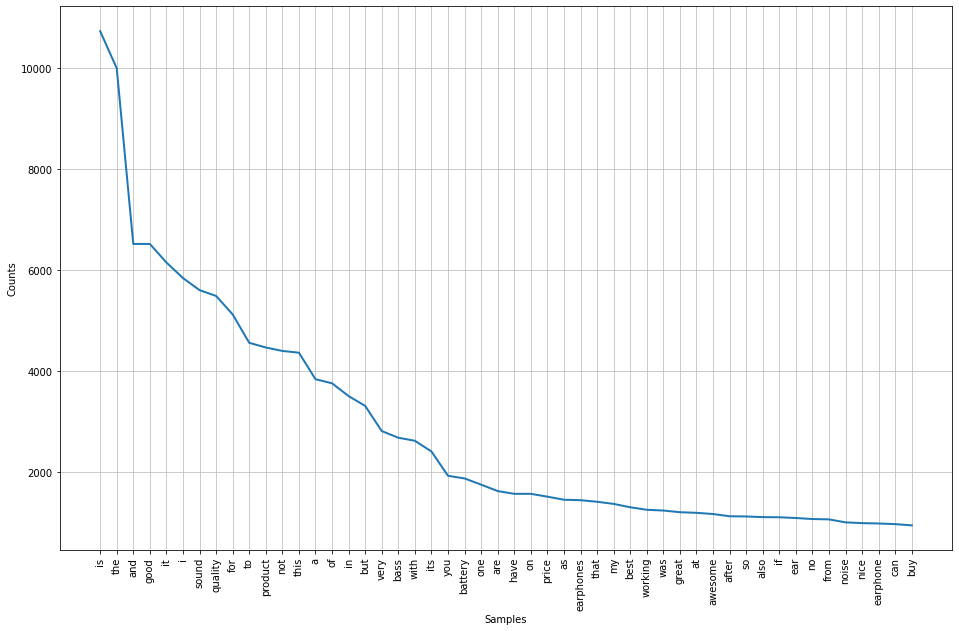

In [16]:
plt.figure(figsize = (16, 10))
freq_dist.plot(50)
plt.show()

The most common words (is,the and...) are usually stopwords and therefore meaningless. However, other common words are relevant, such as quality, sound or good. Also the verb to be appears in many different forms like is, are, was...

#### **1.2.2.3 Standardizing the text**

Once the EDA is performed, we must standardize the text, by removing the stop words (meaningless words, such us determinants and pronouns) and lemmatizing.

In [17]:
from nltk.stem import PorterStemmer 

def get_tokens(text):
    # Get the tokens
    if isinstance(text, nltk.Text):
        tokens = text.tokens
    else:
        tokens = text.split(" ")
        
    return tokens

def remove_stopwords(text, language):
    # Import stopwords
    from nltk.corpus import stopwords
    
    # Get stop words for the given language
    stopwords_list = stopwords.words(language)
    
    # Removing not from stopwords_list as it is a very informative word when doing sentiment analysis
    stopwords_list.remove('not')
    
    # Get the tokens
    tokens = get_tokens(text)
        
    # Remove the words from the text 
    cleaned_text = [w for w in tokens if not w in stopwords_list]
    
    # Return cleaned text
    if isinstance(text, nltk.Text):
        output = nltk.Text(cleaned_text)
    else:
        output = " ".join(cleaned_text)
    
    return output

def stem_text(text, language):
    # Create the stemmer 
    stemmer = PorterStemmer()
    
    # Get the tokens
    tokens = get_tokens(text)
    
    # Stem each token in text object
    stemmas = [stemmer.stem(w) for w in tokens]
    
    # Return stemmed text
    if isinstance(text, nltk.Text):
        output = nltk.Text(stemmas)
    else:
        output = " ".join(stemmas)
    
    return output

def standardize_text(text,language):
    # Remove the stop words
    standardized_text = remove_stopwords(text, language)

    # Stem the text
    standardized_text = stem_text(standardized_text, language)
    
    # Return
    return standardized_text

In [18]:
# Standardize text
standardized_nltk_text = standardize_text(nltk_text, "english")
data['Standardized_Text'] = data.Text_Clean.apply(lambda text: standardize_text(text, "english"))

In [19]:
# Check first row
data[["Text_Clean", "Standardized_Text"]].head(1).values

array([['no doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust bluetooth range not more than pain in ear due the conical buds can be removed wires are a bit long which makes it odd in front no pouch provided worst part is very low quality and distoring mic other person keeps complaining about my voice',
        'doubt great bass great extent nois cancel decent sound clariti mindblow batteri follow dissapoint though tri lot adjust bluetooth rang not pain ear due conic bud remov wire bit long make odd front pouch provid worst part low qualiti distor mic person keep complain voic']],
      dtype=object)

We can then plot again not cumulatively the frequency of the words.

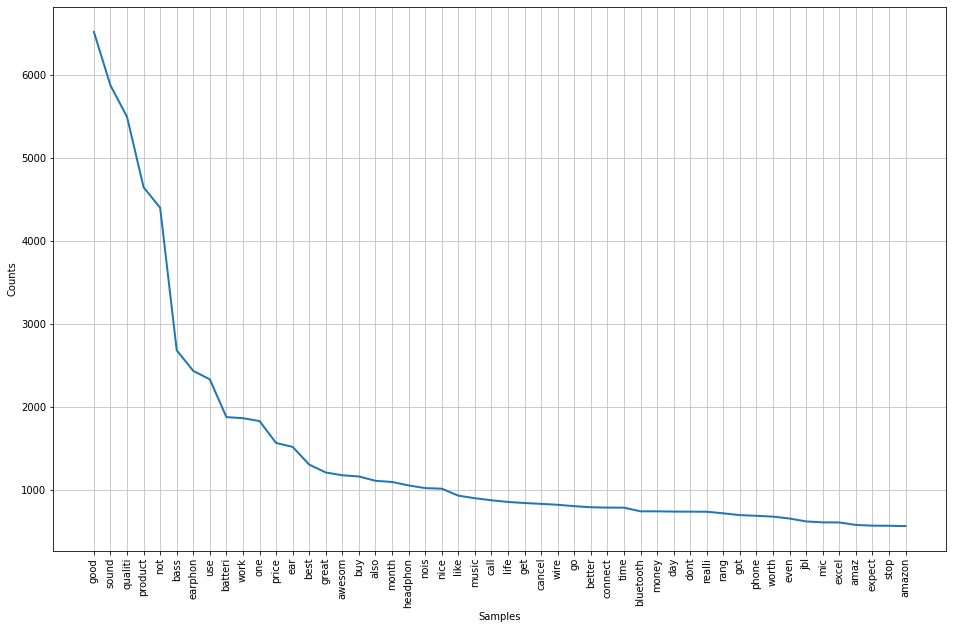

In [20]:
plt.figure(figsize = (16, 10))
nltk.FreqDist(standardized_nltk_text).plot(50)
plt.show()

Now, there are no meaningless words. The most common words indicate why people is satisfied or unsatisfied with the product

### **1.2.3 Relating stars with sentiment**

In order to build up the sentimental analysis model, we need to transform *star* values into sentiments. To do this, we will match them as follows:

- **Bad sentiment**: stars 1 and 2 --> bad
- **Intermediate sentiment**: star 3 --> neutral
- **Good sentiment**: stars 4 and 5 --> good

In [21]:
def star_sentiment_matching(value):
    if value <= 2:
        return 'Bad'
    elif value == 3:
        return 'Neutral'
    else:
        return 'Good'

In [22]:
# Match the sentiment value
data['Sentiment'] = data.Star.apply(lambda value: star_sentiment_matching(value))

# Remove the star field
data = data.drop(columns = ["Star"])

In [23]:
data.Sentiment.value_counts()

Good       8475
Bad        3069
Neutral    1359
Name: Sentiment, dtype: int64

### **1.2.4 Checking dataset imbalance**

Plotting the number of comments per sentiment to determine if the dataset is balanced or not.

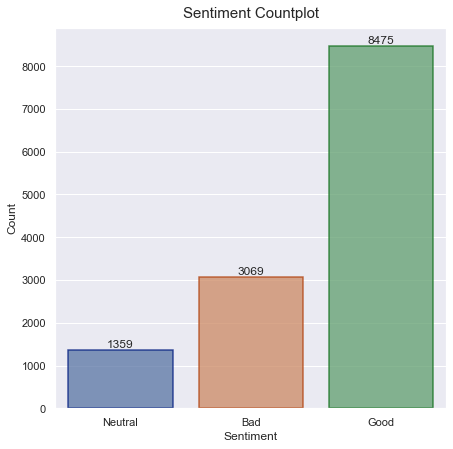

In [24]:
sns.set()
plt.figure(figsize=(7,7))

splot = sns.countplot(x="Sentiment", data=data,linewidth=1.5,edgecolor=sns.color_palette("dark", 3),alpha=0.75,order=['Neutral','Bad','Good',])

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height() + 10), ha = 'center', va= 'bottom', xytext = (0, 0), textcoords = 'offset points')

plt.ylabel('Count')
plt.title('Sentiment Countplot', size=15, pad=10)
plt.show()

The dataset is pretty imbalanced towards the Good sentiment.

# **2. Building the sentimental analysis model**

The objective of this model is to be able to predict if a given customer is disgusted with our product, and in that case, be able to track its evolution and apply any business rule in order to avoid the churner ratio to increase.

The model I decided to develop is based on LSTMs. It will take as input a given text and will output the sentiment related to it. 

### 2.1. Balancing the dataset 

The function *balance_dataset* will balance (or not) the dataset by keeping the same amount of data per class.

In [25]:
def balance_dataset(dataset: pd.DataFrame,
                    sample_number: int,
                    balance: bool = False,
                    replace: bool = False):
    """
    The function returns a balanced version of the provided dataset according to the input parameters.
    
    Parameters:
        - dataset: dataset to be balanced
        - balance: flag that determines if the dataset must be balanced or not.
        - replace: flag that determines if random samples must be replaced when balancing
    """
    if balance:
        return data.groupby('Sentiment').apply(lambda x: x.sample(sample_number,replace = replace) 
                                               if len(x) >= sample_number else x.sample(sample_number,replace = True)
                                              ).reset_index(drop=True)
    
    return dataset   

In [26]:
sample_number = 3000
balance = True
replace = True

# Balance with replacement
training = balance_dataset(dataset = data,
                           sample_number = sample_number,
                           balance = balance,
                           replace = replace)

### 2.2. Converting text into numeric values

LSTMs require the input to be numerical. Therefore, we need to map our text into numerical values, and for this purpose we will tokenize the text and pad it.

In order to establish how many words should we keep, we will plot the distribution and box plot of the text length.

In [27]:
def plot_text_length_distribution(dataset: pd.DataFrame,text_field: str):
    # Compute the vocabulary size for the given text field
    vocabulary_size = len(set(dataset[text_field].values))
    print("\nThe vocabulary is composed by {0} words.\n".format(vocabulary_size))
    
    # Compute the lengths
    lengths = dataset[text_field].apply(lambda x: len(x.split())).value_counts()
    
    # Build the figures
    plt.figure(figsize = (16, 10))
    plt.subplot(211)
    
    # Plot the distribution
    plt.bar(x = lengths.keys(),height = lengths.values, color = 'blue')
    
    # Assign the title
    plt.title("Distribution of the sentences lenght")
    plt.xlabel("Sentence Length")
    plt.ylabel("Number of sentences")

    # Set the second plot
    plt.subplot(212)
    
    # Plot the box plot
    plt.boxplot(x = lengths.keys(), showmeans=True)
    
    plt.suptitle('Lenght of words in %s column' % (text_field))
    
    # Show
    plt.show()


The vocabulary is composed by 5170 words.



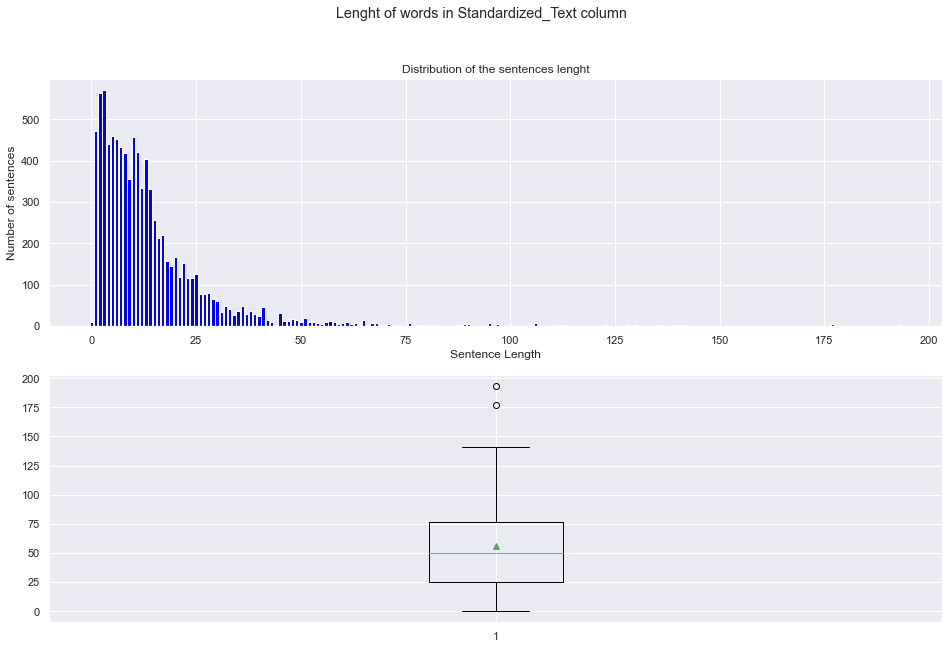

In [28]:
sns.set()

# Define the text field to be used
text_field = "Standardized_Text"

plot_text_length_distribution(dataset = training,
                              text_field = text_field)

Vocabulary is composed by 5100 words and the mean sentence lenght is around 50 words. I have decided to choose 1000 as the maximum number of words to keep as it is more or less 20% of the vocabulary size.

In [29]:
max_num_words = 1000

Convert text into numerical values using Tokenizer and pad_sequences.

In [30]:
def map_text_into_numerical_values(dataset: pd.DataFrame,
                                   text_field: str,
                                   max_num_words: int,
                                   print_info: bool = True,
                                   tokenizer_dict = {}):
    # Tokenize the text
    if tokenizer_dict.get("tokenizer") is None:
        tokenizer = Tokenizer(num_words = max_num_words, split = " ")
        tokenizer.fit_on_texts(dataset[text_field].values)
        tokenizer_dict['tokenizer'] = tokenizer
    else:
        tokenizer = tokenizer_dict.get("tokenizer")
    tokens = tokenizer.texts_to_sequences(dataset[text_field].values)
    
    # Padd the values in order to get the same length
    padded_tokens = pad_sequences(tokens, maxlen = tokenizer_dict.get("max_pad_sequence_length"))
    if tokenizer_dict.get("max_pad_sequence_length") is None:
        tokenizer_dict["max_pad_sequence_length"] = len(padded_tokens[0])
        
    # Print some information
    if print_info:
        for index in range(0, 3):
            print("\n- Original token length: {} \n- Padded token length: {} \n- Text: {} \n- Tokenized text: {} \n- Padded tokenized text: {}".format(len(tokens[index]), 
                                                                                                                                                       len(padded_tokens[index]),
                                                                                                                                                       dataset[text_field].values[index], 
                                                                                                                                                       tokens[index],
                                                                                                                                                       padded_tokens[index]))

    return tokens, padded_tokens, tokenizer_dict

In [31]:
tokens, padded_tokens, tokenizer_dict = map_text_into_numerical_values(dataset = training,
                                                       text_field = text_field,
                                                       max_num_words = max_num_words)


- Original token length: 22 
- Padded token length: 162 
- Text: pro sound qualitycon u plugin mm slot u forc make minor minut adjust mic speaker work sometim bend wire near pin hear voicemi anoth friend bought experi samepremium price 
- Tokenized text: [177, 3, 74, 443, 74, 936, 138, 296, 278, 34, 165, 7, 114, 24, 416, 666, 82, 302, 409, 57, 135, 14] 
- Padded tokenized text: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 177   3  74 443
  74 936 138 296 278  34 165   7 1

<br>

Applying one-hot encoding to sentiment values. 

In [32]:
def map_labels_to_onehot(dataset: pd.DataFrame,
                         label_field: str):
    
    # Return the labels encoded as one-hot
    return pd.get_dummies(dataset[label_field]).values

In [33]:
labels = map_labels_to_onehot(dataset = training, label_field = "Sentiment")

### 2.3. Splitting into training, validation and test datasets

We have already defined the feature values (*padded_tokens*) and the target ones (*labels*). The next step is to split them into training, validation and test datasets in order to be able to train and validate the model.

In [34]:
def split_datasets(x, y, train_percentage = 0.9, validation_precentage = 0.5):
    # Get training dataset
    X_testval, X_train, y_testval, y_train = train_test_split(x, y, test_size = train_percentage)
    
    # Get test and validation datasets
    X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size = validation_precentage)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [35]:
X_train, X_val, X_test, y_train, y_val, y_test = split_datasets(x = padded_tokens, y = labels)

# 3. Build up the model



Build and train the model

In [36]:
def build_model(**params):
    # Build up the LSTM model
    num_classes = labels.shape[1]
    max_sentence_len = padded_tokens.shape[1]
    vocabulary_size = max_num_words
    
    embed_output_size = 128
    lstm_input_size = 196
    
    model_input = Input(shape = (max_sentence_len, ))
    
    embed_layer = Embedding(input_dim = vocabulary_size, output_dim = embed_output_size)
    embed_out = embed_layer(model_input)
    
    dropout_layer = SpatialDropout1D(0.2)
    dropout_out = dropout_layer(embed_out)
    
    lstm_layer = LSTM(lstm_input_size)
    lstm_output = lstm_layer(dropout_out)
    
    dense_layer = Dense(num_classes, activation='softmax')
    model_output = dense_layer(lstm_output)
    
    model = Model(inputs = [model_input], outputs = [model_output])
    model.compile(optimizer = 'Adam', loss = 'CategoricalCrossentropy', metrics =['AUC','accuracy'])
    model.summary()
    
    return model

def train_model(model, **params):
    # Train the model
    model.fit(x = X_train, y = y_train, epochs = epochs ,batch_size = batch_size, validation_data = (X_val,y_val))
    
    return model

In [37]:
# Build the model
model = build_model(padded_tokens = padded_tokens, labels = labels, max_num_words = max_num_words)

epochs = 3
batch_size = 16

# Train the model
model = train_model(model = model, X_train = X_train, y_train = y_train, epochs = epochs,
                    batch_size = batch_size,X_val = X_val, y_val = y_val)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 162, 128)          128000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 162, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 383,391
Trainable params: 383,391
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
507/507 [==============================] - 45s 89ms/step - loss: 0.8515 - auc: 0.8078 - accuracy: 0.6244

Predict the sentiment over the test dataset

In [38]:
def get_prediction(model,data):
    predictions = model.predict(data).argmax(axis=1)
    return predictions

# Maps model output to understandable format
def map_prediction(prediction_array):
    # Define the sentiment dictionary
    sentiment_dictionary = {
        0: "bad", 
        1: "good",
        2: "neutral"
    }
    
    return list(map(sentiment_dictionary.get, prediction_array))

In [39]:
# Predict
predictions = get_prediction(model, data = X_test)

Performs all text transformations seen above to a given text. 

In [40]:
def do_text_transformations(data: pd.DataFrame,
                            text_field: str,
                            max_num_words: int,
                            tokenizer_dict: dict,
                            language: str = "english"):
    # Clean the text
    data['Text_Clean'] = data[text_field].apply(lambda x: clean_text(x))
    
    # Standardize the text
    data['Standardized_Text'] = data.Text_Clean.apply(lambda x: standardize_text(x,language))
    
    # Map text to numerical values
    _, pad_tokens, _ = map_text_into_numerical_values(dataset = data,
                                                      text_field = text_field,
                                                      max_num_words = max_num_words,
                                                      tokenizer_dict = tokenizer_dict,
                                                      print_info = False)
    
    # Assing the mapped text to dataset
    data['Padded_Text'] = list(pad_tokens)
    
    return data

In [41]:
data_report = do_text_transformations(data = data_report,
                                      text_field = "Text",
                                      tokenizer_dict = tokenizer_dict,
                                      max_num_words = max_num_words)

Predict the sentiment for a given text.

In [42]:
def predict_sentiment(model,
                      data: pd.DataFrame,
                      field_to_use: str):
    
    # Predict the sentiment for the given text
    data['Sentiment_Prediction_Raw'] = get_prediction(model,np.stack(data[field_to_use].values))
    
    # Map the prediction
    data['Sentiment_Prediction'] = map_prediction(data['Sentiment_Prediction_Raw'])
    
    return data

In [43]:
data_report = predict_sentiment(model, data = data_report, field_to_use = "Padded_Text")

The functions *get_top_n_most_common_words*, *get_top_n_mainwords*, *get_main_and_related_words* extract a dataframe that indicates the main and related words per sentiment, and indicates which customer has used that words. They will come in handy when creating the dashboard.

In [44]:
def get_top_n_most_common_words(nltk_text: nltk.Text,
                                n: int):
    
    freq_distr = nltk.FreqDist(nltk_text.tokens)

    # Extract the top n most common words from a given text 
    dictionary = {k:v for k,v in freq_distr.most_common(n)}

    # Return
    return dictionary

def get_top_n_mainwords(data: pd.DataFrame,
                        text_field: str,
                        n: int):
    # Initialize the dataframes to be returned
    mainwords_count_df = pd.DataFrame(columns = ["MainWord", "MainWordCount"])
    mainwords_conversation_df = pd.DataFrame(columns=["MainWord", "Id"])
    
    # Get the top n mainwords counts and review ids where the mainwords are presented
    top_n_mainwords = get_top_n_most_common_words(nltk_text = convert_to_nltk_text(data,text_field), n = n)
    
    
    
    mainwords_count_df = mainwords_count_df.append(pd.DataFrame({"MainWord": word, "MainWordCount": count} 
                                                                for word, count in top_n_mainwords.items()),
                                                   ignore_index = True,sort = False)
    for mainword in top_n_mainwords.keys():
        mainword_ids = data[data[text_field].str.contains(mainword) == True]
        mainwords_conversation_df = mainwords_conversation_df.append({"MainWord": mainword,
                                                                      "Id": list(mainword_ids.index)},
                                                                     ignore_index = True,sort = False).explode('Id')
    
    return mainwords_count_df, mainwords_conversation_df    

def get_main_and_related_words_per_sentiment(data: pd.DataFrame,
                                             n_mainwords: int,
                                             n_relatedwords: int,
                                             field_to_use: str,
                                             sentiment_field: str):
    # Initialize the dataframes to be returned
    mainwords_count_df = pd.DataFrame(columns = ["MainWord", "MainWordCount", "Sentiment"])
    mainwords_conversation_df = pd.DataFrame(columns=["MainWord", "Id", "Sentiment"])
    relatedword_per_mainword_df = pd.DataFrame(columns=["MainWord", "RelatedWord", "RelatedWordCount", "Sentiment"])
    
    # Get the mainwords and its related words per sentiment group.
    grouped = data.groupby(by=[sentiment_field], as_index = False)
    for sentiment, grouped_data in grouped:
        
        mainwords_count_df_2, mainwords_conversation_df_2 = get_top_n_mainwords(data = grouped_data,text_field = field_to_use,
                                                                                n = n_mainwords)
        
        for mainword in mainwords_count_df_2.MainWord.unique():
            top_n_common_words = get_top_n_most_common_words(nltk_text = convert_to_nltk_text(grouped_data,field_to_use),
                                                             n = n_relatedwords)

            relatedword_per_mainword_df_2 = pd.DataFrame({"MainWord": mainword, "RelatedWord": word, "RelatedWordCount": count}
                                                        for word, count in top_n_common_words.items())
            
            relatedword_per_mainword_df_2['Sentiment'] = sentiment
            relatedword_per_mainword_df = relatedword_per_mainword_df.append(relatedword_per_mainword_df_2,
                                                                             ignore_index = True,sort = False)

        mainwords_count_df_2['Sentiment'] = sentiment
        mainwords_conversation_df_2['Sentiment'] = sentiment
        
        mainwords_count_df = mainwords_count_df.append(mainwords_count_df_2,ignore_index = True,sort = False)
        mainwords_conversation_df = mainwords_conversation_df.append(mainwords_conversation_df_2,ignore_index = True,sort = False)
        
        relatedword_per_mainword_df = relatedword_per_mainword_df[relatedword_per_mainword_df.MainWord != relatedword_per_mainword_df.RelatedWord]
        
    return mainwords_count_df, mainwords_conversation_df, relatedword_per_mainword_df

In [45]:
mainwords_count_df, mainwords_conversation_df, relatedword_per_mainword_df = get_main_and_related_words_per_sentiment(data = data_report, 
                                                                                                                      n_mainwords = 10,
                                                                                                                      n_relatedwords = 10,
                                                                                                                      sentiment_field = "Sentiment_Prediction",
                                                                                                                      field_to_use = "Standardized_Text")

In [46]:
mainwords_count_df

,MainWord,MainWordCount,Sentiment
0,not,316,bad
1,product,182,bad
2,qualiti,149,bad
3,sound,139,bad
4,work,105,bad
5,good,89,bad
6,use,76,bad
7,month,70,bad
8,ear,65,bad
9,one,65,bad


In [47]:
mainwords_conversation_df

,MainWord,Id,Sentiment
0,not,9033,bad
1,not,10398,bad
2,not,13557,bad
3,not,10038,bad
4,not,6537,bad
...,...,...,...
3631,one,12798,neutral
3632,one,1145,neutral
3633,one,104,neutral
3634,one,4936,neutral


In [48]:
relatedword_per_mainword_df

,MainWord,RelatedWord,RelatedWordCount,Sentiment
0,not,product,182,bad
1,not,qualiti,149,bad
2,not,sound,139,bad
3,not,work,105,bad
4,not,good,89,bad
...,...,...,...,...
274,one,bass,87,neutral
275,one,product,75,neutral
276,one,earphon,66,neutral
277,one,use,63,neutral


In [49]:
data_report.drop(columns=['MRP','ProductFullName','ReviewURL','ReviewTitle'],inplace=True)
data_report

,Price,Product,id,Text,Star,Text_Clean,Standardized_Text,Padded_Text,Sentiment_Prediction_Raw,Sentiment_Prediction
9033,6499,Sennheiser CX 6.0BT,8,4 stars for the treble aspect! Not for bass lo...,4,stars for the treble aspect not for bass lover...,star trebl aspect not bass lover headphon not ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,bad
11376,6499,Sennheiser CX 6.0BT,8,Good product sound is to goodReally enjoy good...,4,good product sound is to goodreally enjoy good...,good product sound goodreal enjoy good qualiti...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
9603,6499,Sennheiser CX 6.0BT,8,The Product Is of utmost quality and the sound...,5,the product is of utmost quality and the sound...,product utmost qualiti sound absolut mesmeris ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
12697,2000,JBL T110BT,10,BATTERY LIFEThese JBL BT Earphones has bad bat...,4,battery lifethese jbl bt earphones has bad bat...,batteri lifethes jbl bt earphon bad batteri li...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,neutral
8269,6499,Sennheiser CX 6.0BT,8,"Pros: This is the best earphone, supported my ...",5,pros this is the best earphone supported my re...,pro best earphon support redmi note build qual...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
...,...,...,...,...,...,...,...,...,...,...
4768,1399,boAt Rockerz 255,1,Best in this class\n,5,best in this class,best class,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
7990,6499,Sennheiser CX 6.0BT,8,Awesome headsets at low budget... Sennheiser p...,5,awesome headsets at low budget sennheiser prov...,awesom headset low budget sennheis prove one w...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
7509,6499,Sennheiser CX 6.0BT,8,Man..I loved these earpiece..This is a must ha...,5,man i loved these earpiece this is a must have...,man love earpiec must thing bass music qualiti...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good
14253,2000,JBL T110BT,10,Durability\n,5,durability,durabl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,good


Saving *data_report*, *mainwords_count_df*, *mainwords_conversation_df*, *relatedword_per_mainword_df* to build up a dashboard with the idea of helping Customer Service to quickly understand what customers think about their product, identify those unsatisfied customers and see the main and related words.

In [50]:
data_report.to_csv('./Datasets/data_report.csv')
mainwords_count_df.to_csv('./Datasets/mainwords_count_df.csv')
mainwords_conversation_df.to_csv('./Datasets/mainwords_conversation_df.csv')
relatedword_per_mainword_df.to_csv('./Datasets/relatedword_per_mainword_df.csv')

## Dashboard

The dashboard can be found in Tableau Public using this [link](https://public.tableau.com/views/TextAnalyticsonCustomersReviews/ProductReviewsAnalysis?:language=es&:display_count=y&publish=yes&:origin=viz_share_link).